# Motion segmentation

In [1]:
# For Kmeans algorithm. See PGM otherwise for handcrafted class
from sklearn.cluster import KMeans
# For loading matlab matrix file
from scipy.io import loadmat
# Hungarian algorithm
from scipy.optimize import linear_sum_assignment

#from scipy.sparse.linalg import eigs, eigsh
from scipy.stats import itemfreq
import numpy as np

#Progressbar
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.5f
%load_ext line_profiler

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

In [3]:
#Algorithm and error
from error_evaluation import *
from ksubspaces import *
from spectral_clustering import *
from SSC import *

In [4]:
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

Extrait de 

@article{elhamifar2013sparse,

  title={Sparse subspace clustering: Algorithm, theory, and applications},
  
  author={Elhamifar, Ehsan and Vidal, Rene},
  
  journal={IEEE transactions on pattern analysis and machine intelligence},
  
  volume={35},
  
  number={11},
  
  pages={2765--2781},
  
  year={2013},
  
  publisher={IEEE}
  
}


![article](real_data_article.png)

## Globals

In [5]:
DATA_DIR = "data/Hopkins155/"
NEEDLE = "_truth.mat"

## Data

In [6]:
import glob
import os

In [7]:
motion_data = {}
count_files = 0
# iglob for iterator
## Recursive=True to use **
for file in glob.iglob(DATA_DIR + "**/*" + NEEDLE, recursive = True):
    mat_name = file.split("/")[-1].split(NEEDLE)[0]
    try:
        # Load matlab matrix
        motion_data[mat_name] = loadmat(file)
        # Cast in float64 x
        motion_data[mat_name]['x'] = motion_data[mat_name]\
        ['x'].astype(np.float64, subok = True, copy = False)
        # Cast number of points in int
        motion_data[mat_name]['points'] = motion_data[mat_name]\
        ['points'][0, 0].astype(int)
        # Cast number of frames in int
        motion_data[mat_name]['frames'] = motion_data[mat_name]\
        ['frames'][0, 0].astype(int)
        # Substract 1 to matlab labels
        motion_data[mat_name]['s'] -= 1
    except OSError:
        print ('cannonot open ', file)
    else:
        count_files += 1
        motion_data[mat_name]["data"] = \
        np.transpose(motion_data[mat_name]['x'][:2, : :],
                     axes = (0, 2, 1)).reshape(2 * motion_data[mat_name]['frames'],
                                               motion_data[mat_name]["points"])
print ("Number of files loaded : {}".format(count_files))

Number of files loaded : 156


## Results zone : SSC

In [257]:
SSC_res = np.load('motion_res_SSC.npy').item()

### $tau = 1e3$, $mu=1e3$

In [38]:
tau = 1e3
mu = 1e3

In [44]:
Res[(tau, mu)] = {}
for key in tqdm(motion_data.keys()):
    # Number of ground_truth classes
    nbr_classes = motion_data[key]["s"].max() + 1
    Res[(tau, mu)][key] = evaluate_error(SSC(motion_data[key]["data"], nbr_classes, tau, mu)[1],
                              motion_data[key]["s"].reshape(-1))

### $tau = 1e4$, $mu=1e3$

In [65]:
tau = 1e4
mu = 1e3
Res[(tau, mu)] = {}
for key in tqdm(motion_data.keys()):
    # Number of ground_truth classes
    nbr_classes = motion_data[key]["s"].max() + 1
    Res[(tau, mu)][key] = evaluate_error(SSC(motion_data[key]["data"], nbr_classes, tau, mu)[1],
                              motion_data[key]["s"].reshape(-1))

100%|██████████| 156/156 [24:43<00:00,  9.51s/it]


In [259]:
tau = 1e4
for mu in [1e1, 1e2, 1e4, 1e5, 1e6, 1e7]:
    SSC_res[(tau, mu)] = {}
    for key in tqdm(motion_data.keys()):
        # Number of ground_truth classes
        nbr_classes = motion_data[key]["s"].max() + 1
        SSC_res[(tau, mu)][key] = evaluate_error(SSC(motion_data[key]["data"], nbr_classes, tau, mu)[1],
                                             motion_data[key]["s"].reshape(-1))

100%|██████████| 156/156 [03:02<00:00,  1.17s/it]


### $tau = 1e5$, $mu=1e3$

In [68]:
tau = 1e5
mu = 1e3
Res[(tau, mu)] = {}
for key in tqdm(motion_data.keys()):
    # Number of ground_truth classes
    nbr_classes = motion_data[key]["s"].max() + 1
    Res[(tau, mu)][key] = evaluate_error(SSC(motion_data[key]["data"], nbr_classes, tau, mu)[1],
                              motion_data[key]["s"].reshape(-1))

100%|██████████| 156/156 [23:49<00:00,  9.16s/it]


### $tau = 1e6$, $mu=1e3$

In [82]:
tau = 1e6
mu = 1e3
Res[(tau, mu)] = {}
for key in tqdm(motion_data.keys()):
    # Number of ground_truth classes
    nbr_classes = motion_data[key]["s"].max() + 1
    Res[(tau, mu)][key] = evaluate_error(SSC(motion_data[key]["data"], nbr_classes, tau, mu)[1],
                              motion_data[key]["s"].reshape(-1))

100%|██████████| 156/156 [19:55<00:00,  7.66s/it]


### $tau = 1e7$, $mu=1e3$

In [92]:
tau = 1e7
mu = 1e3
Res[(tau, mu)] = {}
for key in tqdm(motion_data.keys()):
    # Number of ground_truth classes
    nbr_classes = motion_data[key]["s"].max() + 1
    Res[(tau, mu)][key] = evaluate_error(SSC(motion_data[key]["data"], nbr_classes, tau, mu)[1],
                              motion_data[key]["s"].reshape(-1))

100%|██████████| 156/156 [32:19<00:00, 12.43s/it]


In [264]:
# np.save('motion_res_SSC.npy', SSC_res)

## Results zone : K-subspace
Figure 11.4 shows the singular values of the matrix of feature point trajectories
of a single motion for several videos in the data set. Note that the singular value
curve has a knee around 4, corroborating the approximate 4-dimensionality of the
motion data in each video.

In [7]:
#K_sub = {}
K_sub = np.load("motion_res_ksub.npy").item()

In [31]:
for restarts in [1, 3, 5, 10, 20, 50, 100, 200, 500]:
    K_sub[restarts] = {}
    for key in tqdm(motion_data.keys()):
        # Number of ground_truth classes
        nbr_classes = motion_data[key]["s"].max() + 1
        K_sub[restarts][key] = evaluate_error(ksubspaces(motion_data[key]["data"], nbr_classes,
                                                         nbr_classes * [4], restarts)[0][0],
                                              motion_data[key]["s"].reshape(-1))
#np.save('motion_res_ksub.npy', K_sub)


 57%|█████▋    | 89/156 [00:30<00:22,  2.96it/s]
Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 156/156 [2:23:14<00:00, 55.09s/it] 


## Spectral clustering 

In [214]:
SC_res = np.load('motion_res_SC.npy').item()
SC_key_param = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 20, 30, 50]

In [209]:
for k in SC_key_param:
    for s in [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]:
        SC_res[(k, s)] = {}
        for key in tqdm(motion_data.keys()):
            W = gaussian_affinity(motion_data[key]["data"], k, s)
            # Number of ground_truth classes
            nbr_classes = motion_data[key]["s"].max() + 1
            SC_res[(k, s)][key] = evaluate_error(SC(W, nbr_classes), motion_data[key]["s"].reshape(-1))
np.save("motion_res_SC.npy", SC_res)

100%|██████████| 156/156 [00:13<00:00, 11.81it/s]


## Exploitation

In [110]:
SSC_res = np.load('motion_res_SSC.npy').item()
K_sub = np.load("motion_res_ksub.npy").item()
SC_res = np.load('motion_res_SC.npy').item()

### Sequences = f(missclassification)

In [229]:
lines = ['.', "-","--","-.",":", (0, (3, 1, 1, 1))]
colors = ["black", "red", "lightcoral", "turquoise", "magenta", "olive", "lime", "gray", "gold", "blue"]
from itertools import cycle
linecycler = cycle(lines)

In [205]:
SC_res.keys()

dict_keys([(1, 10000.0), (10, 1000.0), (8, 100000.0), (6, 1000.0), (2, 10000.0), (2, 1.0), (8, 10.0), (3, 1000.0), (1, 1000.0), (7, 10000.0), (5, 100000.0), (5, 1.0), (7, 1000.0), (2, 100.0), (9, 1.0), (3, 1.0), (10, 100.0), (4, 1000.0), (8, 1.0), (2, 1000.0), (3, 10.0), (6, 10.0), (6, 100000.0), (3, 100.0), (7, 10.0), (3, 10000.0), (1, 100000.0), (8, 10000.0), (4, 1.0), (1, 1.0), (5, 1000.0), (4, 10.0), (9, 100000.0), (6, 100.0), (7, 100000.0), (7, 1.0), (4, 100.0), (4, 10000.0), (9, 10.0), (2, 100000.0), (9, 10000.0), (8, 1000.0), (10, 1.0), (10, 100000.0), (2, 10.0), (8, 100.0), (7, 100.0), (5, 100.0), (5, 10.0), (5, 10000.0), (10, 10.0), (3, 100000.0), (10, 10000.0), (6, 1.0), (1, 10.0), (1, 100.0), (6, 10000.0), (9, 100.0), (9, 1000.0), (4, 100000.0)])

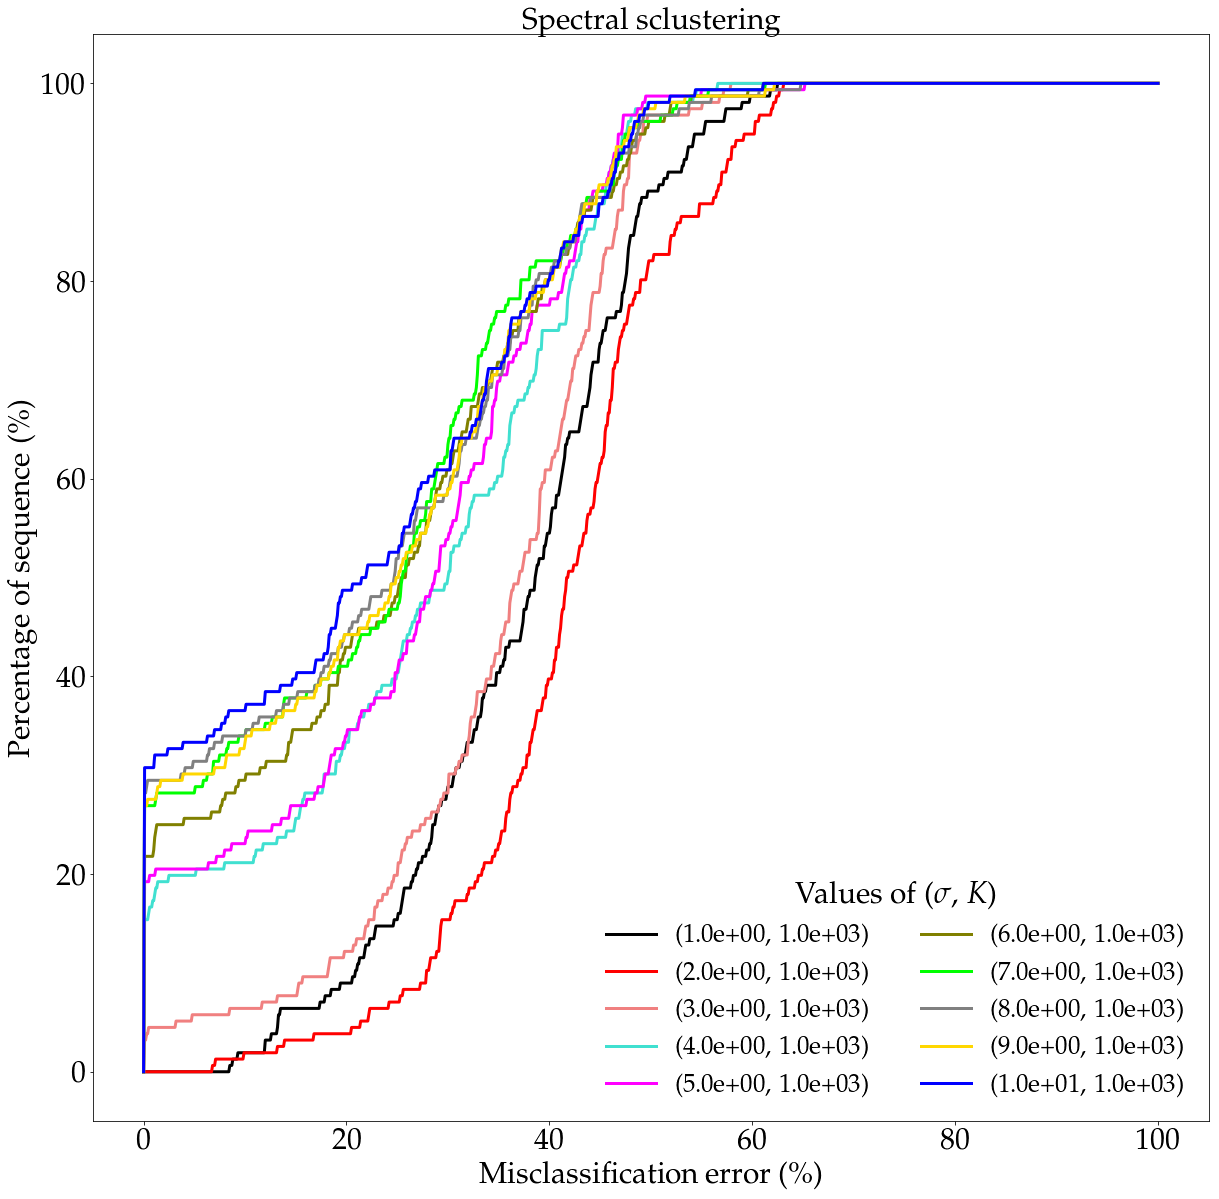

In [230]:
step = 0.001
X = 100 * np.arange(0, 1 + step, step)

plt.figure(figsize = (20, 20))


Params = list(SC_res.keys())
Params.sort()
SS
# for params in Params:
for params in [(SC_key_param[i], 1e3) for i in range(10)]:
    Y = [0] * len(X)
    for x in range(len(X)):
        for key in SC_res[params].keys():
            if SC_res[params][key] < X[x] / 100:
                Y[x] += 100/len(SC_res[params])
    plt.plot(X, Y, color = colors[SC_key_param.index(params[0])], lw = 3,
             label = "({:.1e}, {:.1e})".format(params[0], params[1]));
plt.title("Spectral sclustering", size = 30)
plt.ylabel(r"Percentage of sequence (\%)", size = 30)
plt.xlabel(r"Misclassification error (\%)", size = 30)
leg = plt.legend(fontsize = 25, ncol = 2, frameon=False);
leg.set_title(r"Values of ($\sigma$, $K$)" , prop = {'size': 30})
plt.savefig("../report/images/SC_1e3.png")

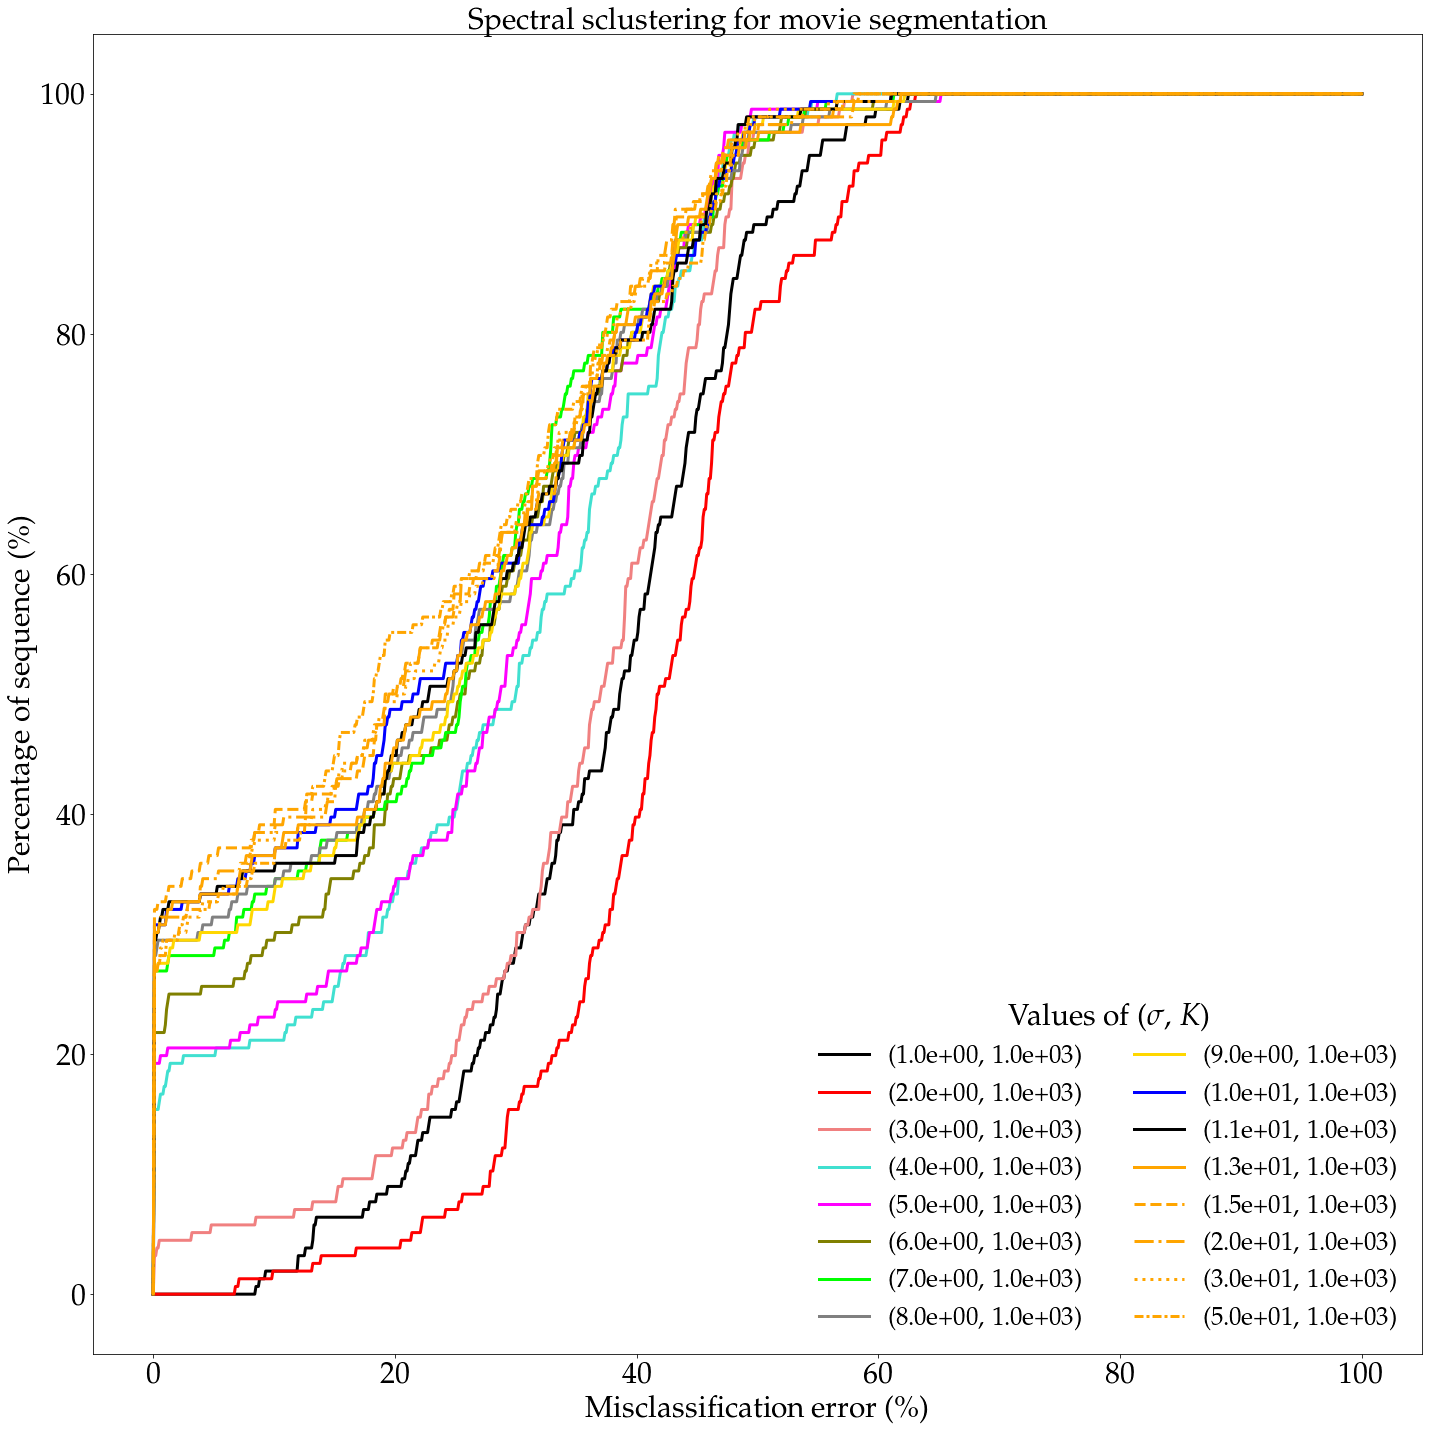

In [249]:
step = 0.001
X = 100 * np.arange(0, 1 + step, step)

plt.figure(figsize = (20, 20))


Params = list(SC_res.keys())
Params.sort()

# for params in Params:
for params in [(SC_key_param[i], 1e3) for i in range(len(SC_key_param))]:
    Y = [0] * len(X)
    for x in range(len(X)):
        for key in SC_res[params].keys():
            if SC_res[params][key] < X[x] / 100:
                Y[x] += 100/len(SC_res[params])
    if SC_key_param.index(params[0]) > 10:
        ls = lines[SC_key_param.index(params[0]) - 10]
        color = "orange"
    else:
        ls = "solid"
        color = colors[SC_key_param.index(params[0]) % len(colors)]
    plt.plot(X, Y, color = color, lw = 3, ls = ls,
             label = "({:.1e}, {:.1e})".format(params[0], params[1]));
plt.title("Spectral sclustering for movie segmentation", size = 30)
plt.ylabel(r"Percentage of sequence (\%)", size = 30)
plt.xlabel(r"Misclassification error (\%)", size = 30)
leg = plt.legend(fontsize = 25, ncol = 2, frameon=False);
leg.set_title(r"Values of ($\sigma$, $K$)" , prop = {'size': 30})
plt.tight_layout()
#plt.savefig("../report/images/SC_1e3.png")

In [239]:
SC_res[(8, 1e3)]

{'1R2RC': 0.46187,
 '1R2RCR': 0.24689,
 '1R2RCR_g12': 0.00000,
 '1R2RCR_g13': 0.17414,
 '1R2RCR_g23': 0.26620,
 '1R2RCT_A': 0.24703,
 '1R2RCT_A_g12': 0.37113,
 '1R2RCT_A_g13': 0.03691,
 '1R2RCT_A_g23': 0.37143,
 '1R2RCT_B': 0.42794,
 '1R2RCT_B_g12': 0.32973,
 '1R2RCT_B_g13': 0.21166,
 '1R2RCT_B_g23': 0.31714,
 '1R2RC_g12': 0.00000,
 '1R2RC_g13': 0.26627,
 '1R2RC_g23': 0.38378,
 '1R2TCR': 0.40108,
 '1R2TCRT': 0.25646,
 '1R2TCRT_g12': 0.00000,
 '1R2TCRT_g13': 0.21485,
 '1R2TCRT_g23': 0.29535,
 '1R2TCR_g12': 0.00000,
 '1R2TCR_g13': 0.18248,
 '1R2TCR_g23': 0.15145,
 '1RT2RCR': 0.33943,
 '1RT2RCRT': 0.25116,
 '1RT2RCRT_g12': 0.46032,
 '1RT2RCRT_g13': 0.33724,
 '1RT2RCRT_g23': 0.04848,
 '1RT2RCR_g12': 0.00000,
 '1RT2RCR_g13': 0.38360,
 '1RT2RCR_g23': 0.33143,
 '1RT2RTCRT_A': 0.60671,
 '1RT2RTCRT_A_g12': 0.00000,
 '1RT2RTCRT_A_g13': 0.42023,
 '1RT2RTCRT_A_g23': 0.00000,
 '1RT2RTCRT_B': 0.55949,
 '1RT2RTCRT_B_g12': 0.43114,
 '1RT2RTCRT_B_g13': 0.33956,
 '1RT2RTCRT_B_g23': 0.24834,
 '1RT2TC': 0

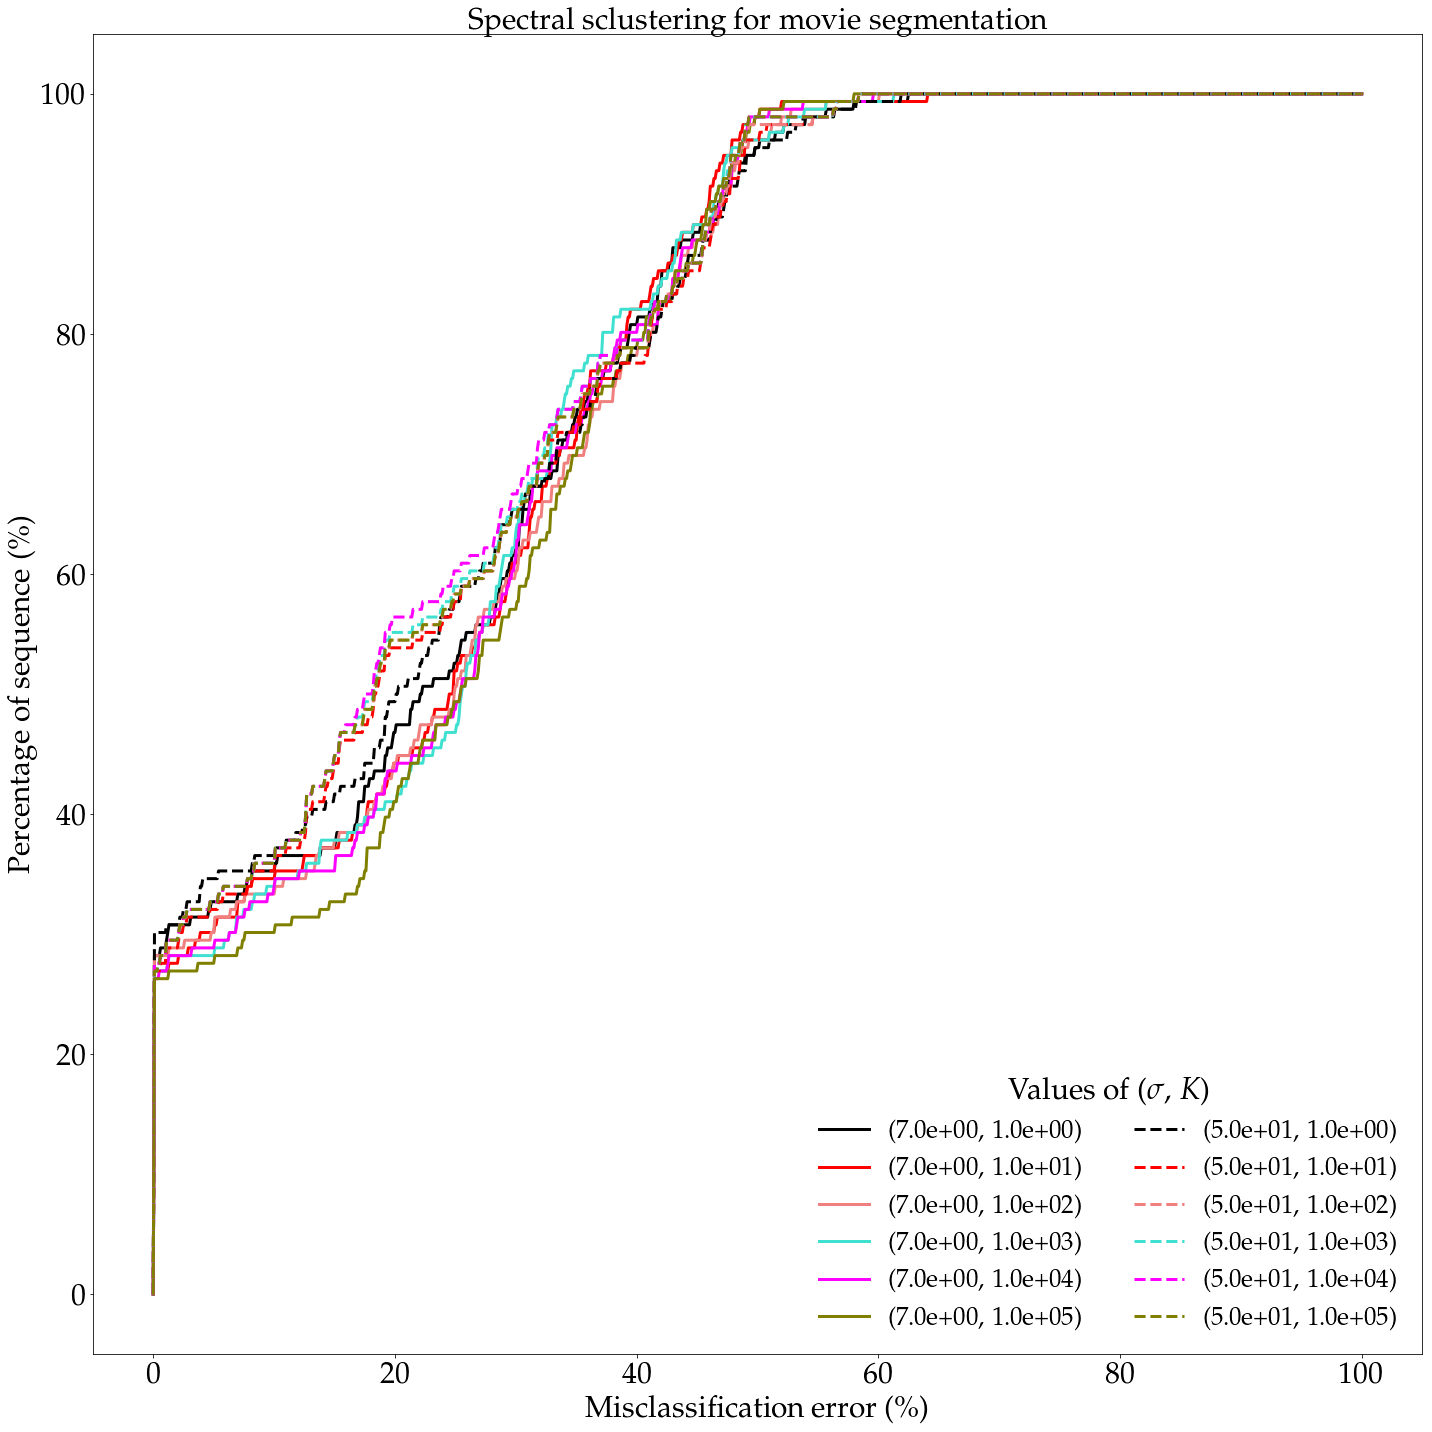

In [251]:
step = 0.001
X = 100 * np.arange(0, 1 + step, step)

plt.figure(figsize = (20, 20))


Params = list(SC_res.keys())
Params.sort()

# for params in Params:
for params in [(7, 10**i) for i in range(6)]:
    Y = [0] * len(X)
    for x in range(len(X)):
        for key in SC_res[params].keys():
            if SC_res[params][key] < X[x] / 100:
                Y[x] += 100/len(SC_res[params])
    plt.plot(X, Y, color = colors[int(np.log10(params[1]))], lw = 3,
             label = "({:.1e}, {:.1e})".format(params[0], params[1]));
for params in [(50, 10**i) for i in range(6)]:
    Y = [0] * len(X)
    for x in range(len(X)):
        for key in SC_res[params].keys():
            if SC_res[params][key] < X[x] / 100:
                Y[x] += 100/len(SC_res[params])
    plt.plot(X, Y, color = colors[int(np.log10(params[1]))], lw = 3, ls = "dashed",
             label = "({:.1e}, {:.1e})".format(params[0], params[1]));
plt.title("Spectral sclustering for movie segmentation", size = 30)
plt.ylabel(r"Percentage of sequence (\%)", size = 30)
plt.xlabel(r"Misclassification error (\%)", size = 30)
leg = plt.legend(fontsize = 25, ncol = 2, frameon=False);
leg.set_title(r"Values of ($\sigma$, $K$)" , prop = {'size': 30})
plt.tight_layout()
# plt.savefig("../report/images/SC_k_7_50.png")

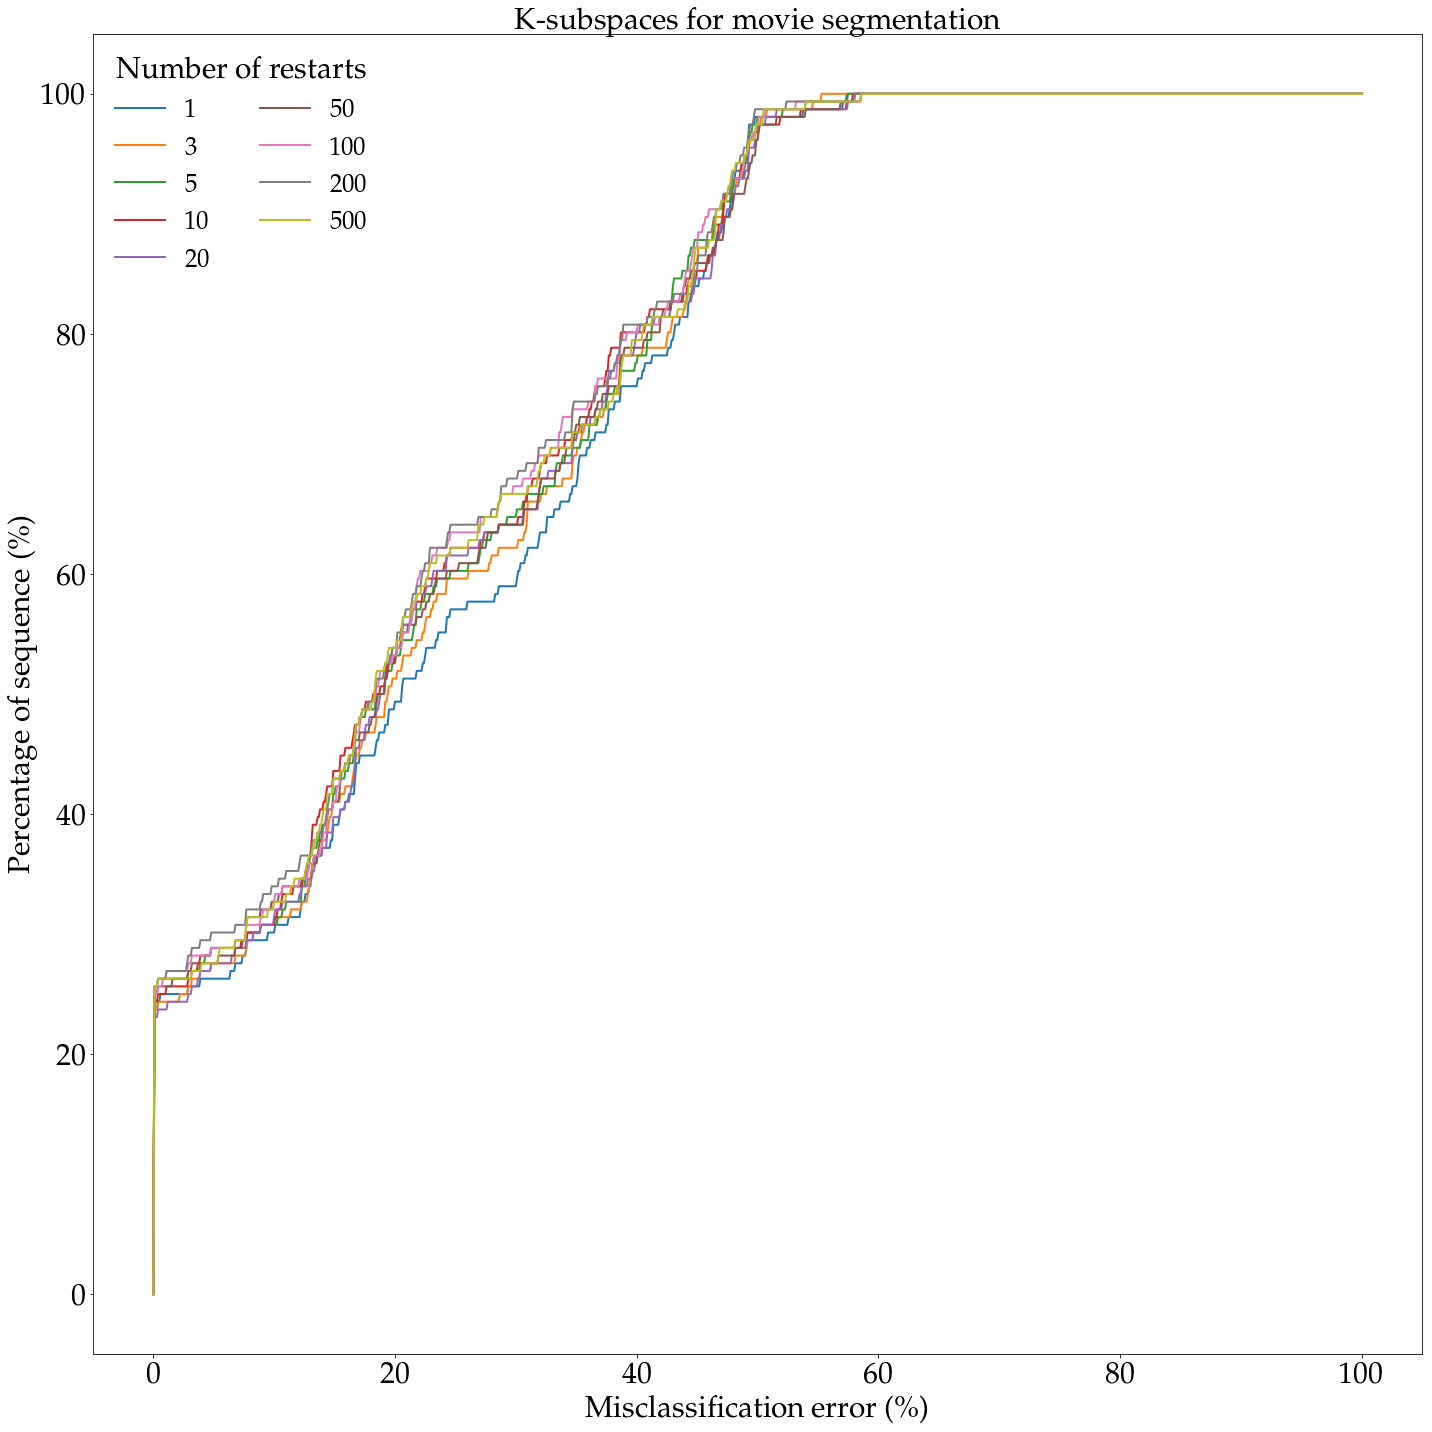

In [283]:
step = 0.001
X = 100 * np.arange(0, 1 + step, step)

plt.figure(figsize = (20, 20))

Params = list(K_sub.keys())
Params.sort()
for params in Params:
    Y = [0] * len(X)
    for x in range(len(X)):
        for key in K_sub[params].keys():
            if K_sub[params][key] < X[x] / 100:
                Y[x] += 100/len(K_sub[params])
    plt.plot(X, Y, label = params, lw = 2);
plt.title("K-subspaces for movie segmentation", size = 30)
plt.ylabel(r"Percentage of sequence (\%)", size = 30)
plt.xlabel(r"Misclassification error (\%)", size = 30)
leg = plt.legend(fontsize = 25, ncol = 2, frameon=False);
leg.set_title("Number of restarts" , prop = {'size': 30})
plt.tight_layout()
# plt.savefig("../report/images/k_sub.png")

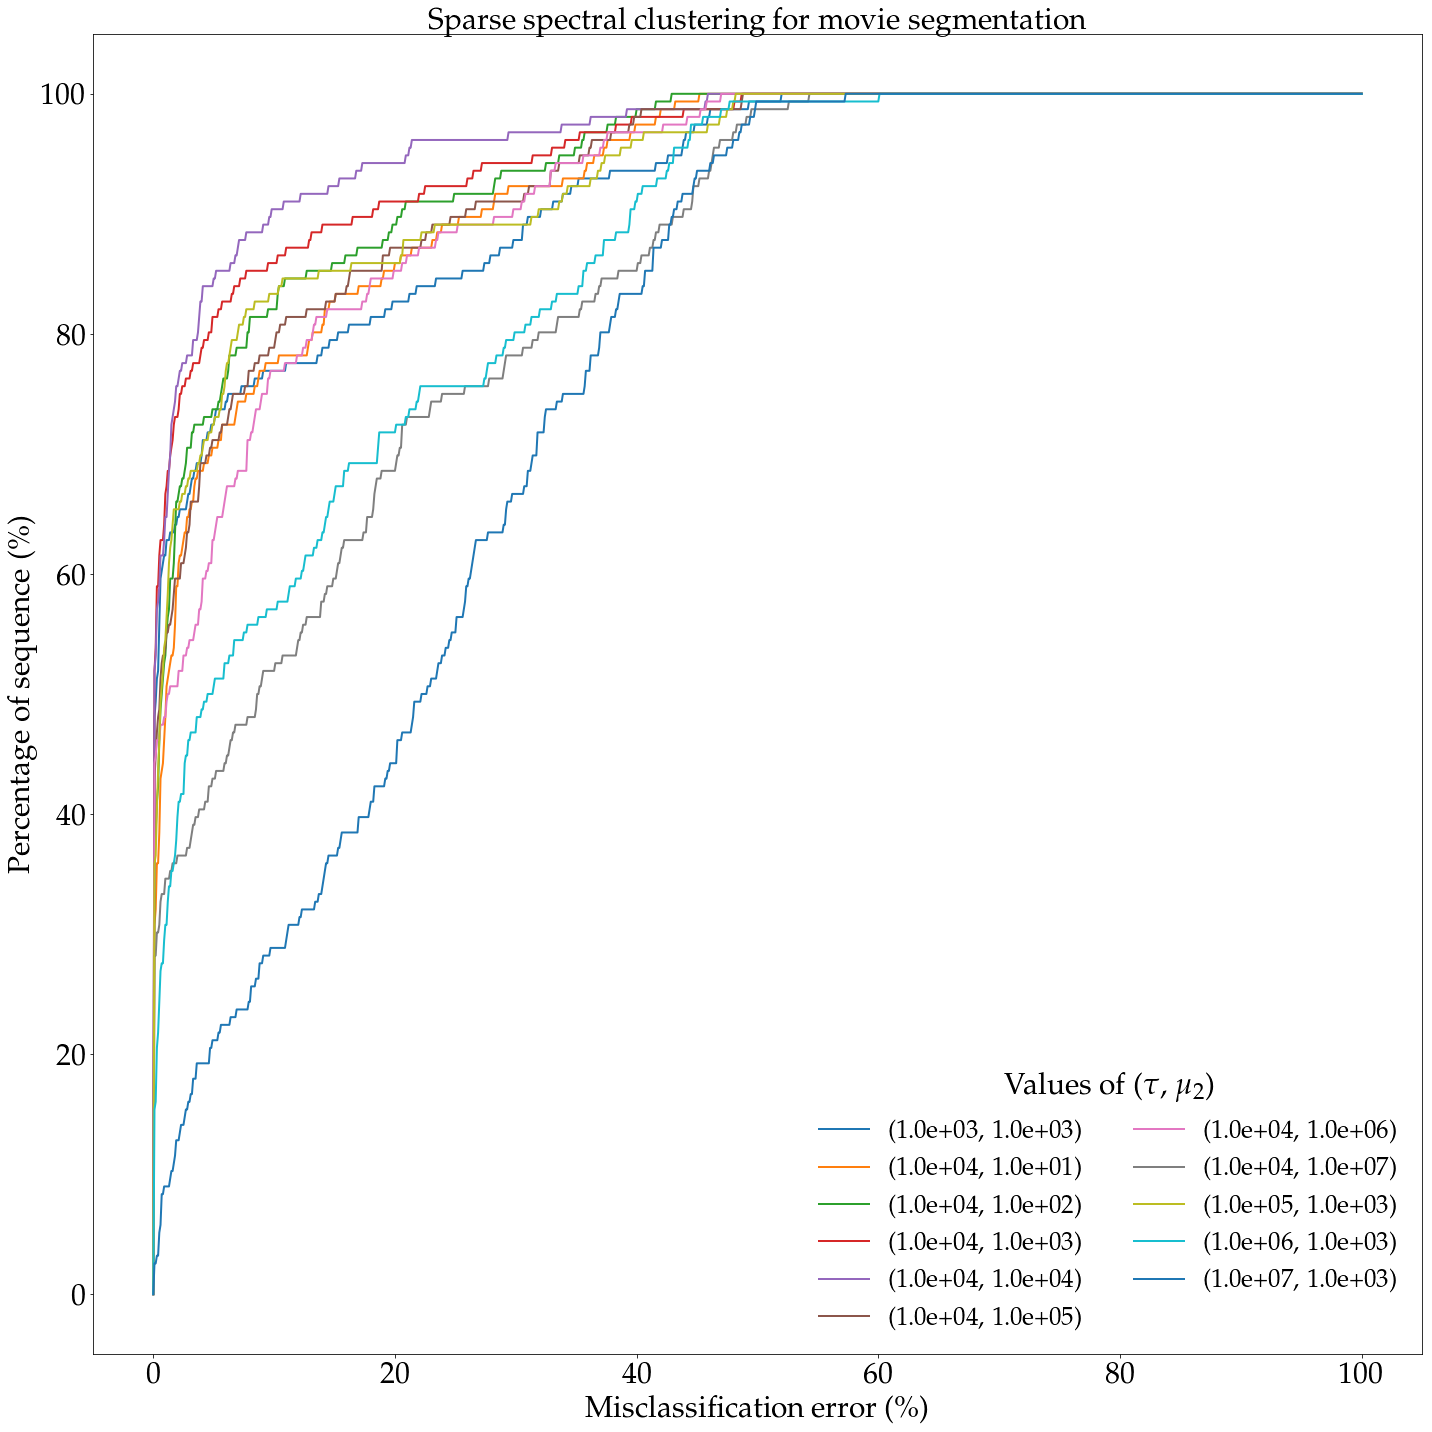

In [284]:
step = 0.001
X = 100 * np.arange(0, 1 + step, step)

plt.figure(figsize = (20, 20))

Params = list(SSC_res.keys())
Params.sort()
for params in Params:
    Y = [0] * len(X)
    for x in range(len(X)):
        for key in SSC_res[params].keys():
            if SSC_res[params][key] < X[x] / 100:
                Y[x] += 100/len(SSC_res[params])
    plt.plot(X, Y, label = "({:.1e}, {:.1e})".format(params[0], params[1]), lw = 2);
plt.title("Sparse spectral clustering for movie segmentation", size = 30)
plt.ylabel(r"Percentage of sequence (\%)", size = 30)
plt.xlabel(r"Misclassification error (\%)", size = 30)
leg = plt.legend(fontsize = 25, ncol = 2, frameon=False);
leg.set_title(r"Values of ($\tau$, $\mu_2$)" , prop = {'size': 30})
plt.tight_layout()
# plt.savefig("../report/images/SSC_tau.png")

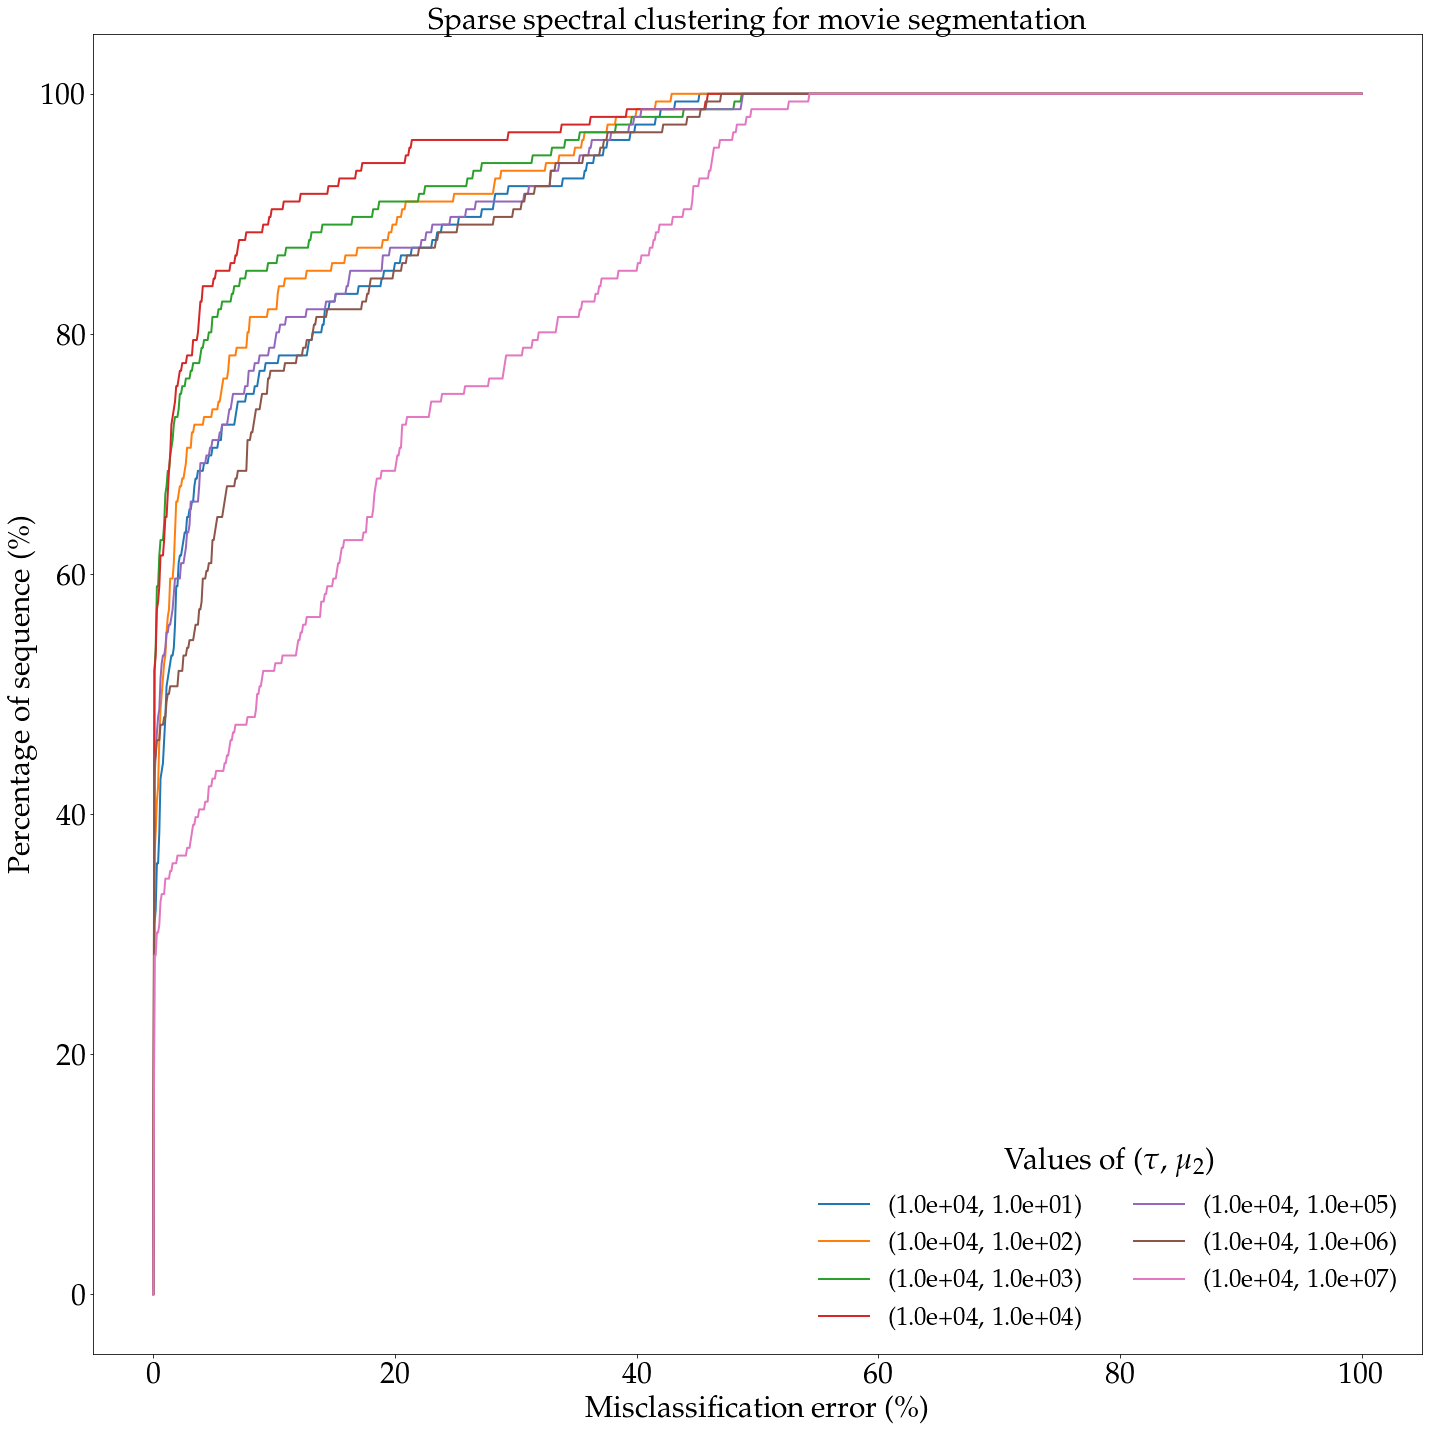

In [285]:
step = 0.001
X = 100 * np.arange(0, 1 + step, step)

plt.figure(figsize = (20, 20))

Params = list(SSC_res.keys())
Params.sort()
for params in [(1e4, 10**i) for i in range(1, 8)]:
    Y = [0] * len(X)
    for x in range(len(X)):
        for key in SSC_res[params].keys():
            if SSC_res[params][key] < X[x] / 100:
                Y[x] += 100/len(SSC_res[params])
    plt.plot(X, Y, label = "({:.1e}, {:.1e})".format(params[0], params[1]), lw = 2);
plt.title("Sparse spectral clustering for movie segmentation", size = 30)
plt.ylabel(r"Percentage of sequence (\%)", size = 30)
plt.xlabel(r"Misclassification error (\%)", size = 30)
leg = plt.legend(fontsize = 25, ncol = 2, frameon=False);
leg.set_title(r"Values of ($\tau$, $\mu_2$)" , prop = {'size': 30})
plt.tight_layout()
# plt.savefig("../report/images/SSC_mu2.png")

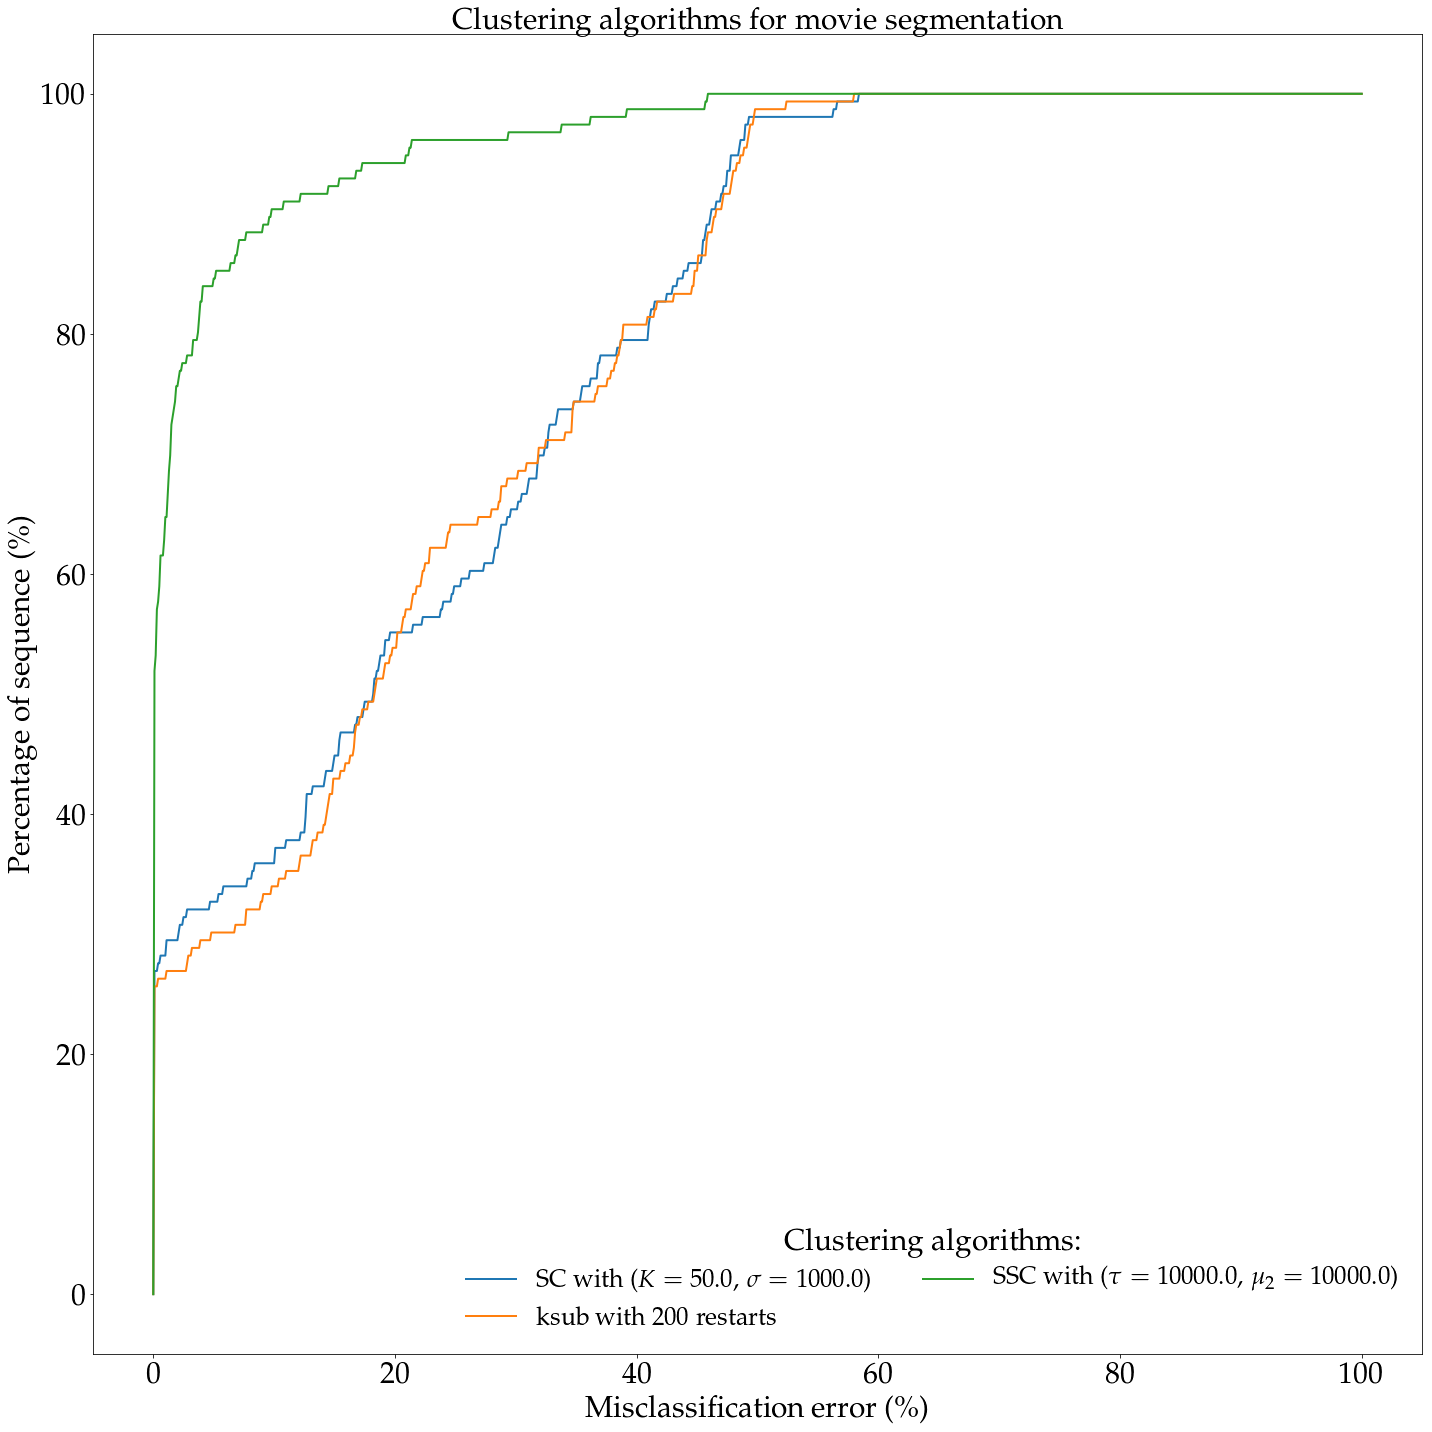

In [291]:
# Comparaison with best of each algorithm
step = 0.001
X = 100 * np.arange(0, 1 + step, step)

plt.figure(figsize = (20, 20))

best_param = {
    "SC" : (5e1, 1e3),
    "ksub" : 200,
    "SSC": (1e4, 1e4)
}

for algo in ["SC", "ksub", "SSC"]:
    if algo == "SSC":
        d = SSC_res
    elif algo == "ksub":
        d = K_sub
    else:
        d = SC_res
    Y = [0] * len(X)
    for x in range(len(X)):
        for key in d[best_param[algo]].keys():
            if d[best_param[algo]][key] < X[x] / 100:
                Y[x] += 100/len(d[best_param[algo]])
    if algo == "SC":
        plt.plot(X, Y, label = r"{} with ($K = {:.1f}$, $\sigma = {:.1f}$)"\
                 .format(algo, best_param[algo][0], best_param[algo][1]), lw = 2);
    elif algo == "SSC":
        plt.plot(X, Y, label = r"{} with ($\tau = {:.1f}$, $\mu_2 = {:.1f}$)"\
                 .format(algo, best_param[algo][0], best_param[algo][1]), lw = 2);
    else:
        plt.plot(X, Y, label = "{} with {} restarts"\
                 .format(algo, best_param[algo]), lw = 2);
plt.title("Clustering algorithms for movie segmentation", size = 30)
plt.ylabel(r"Percentage of sequence (\%)", size = 30)
plt.xlabel(r"Misclassification error (\%)", size = 30)
leg = plt.legend(fontsize = 25, ncol = 2, frameon=False);
leg.set_title(r"Clustering algorithms: " , prop = {'size': 30})
plt.tight_layout()
# plt.savefig("../report/images/auc_compare.png")

## Mean and median of the algorithms for different parameters for each category of Hopkins 155

In [187]:
for key in motion_data.keys():
    print (key)

cars3_g23
2R3RTCRT_g12
1RT2TCRT_A_g12
cars10_g13
1R2RCR
cars9_g12
2RT3RTCRT
cars2_07
truck2
1R2TCRT
1R2RCT_B_g23
1R2TCRT_g12
cars9_g13
kanatani2
1RT2RTCRT_B_g13
cars5_g13
2T3RCR_g12
2R3RTCRT_g13
2RT3RCT_A
2T3RTCR_g12
2RT3RCT_A_g23
2T3RCRT_g13
cars1
1R2RCR_g23
1RT2RCR_g12
two_cranes_g23
2RT3RCT_B_g23
cars7
cars2
2RT3RCT_A_g13
2RT3RTCRT_g12
cars2B_g12
1R2RCT_B
1RT2RTCRT_B
2RT3RTCRT_g23
1RT2RCRT
articulated_g12
cars2_07_g23
cars2B_g13
2T3RCTP_g13
1R2TCRT_g13
1R2TCR_g13
cars3_g12
2RT3RCT_B_g13
2T3RCTP_g12
1RT2RTCRT_A
2T3RCRT
2T3RCTP
1R2RCT_B_g13
cars2_07_g13
articulated_g13
cars2B
people2
2R3RTC_g12
1R2RCT_A_g23
cars9_g23
1R2RCT_A_g12
2T3RCRTP_g13
1RT2TC_g13
cars2_06_g12
2T3RCRT_g23
2T3RCTP_g23
cars2_06
2T3RCR
cars2B_g23
2RT3RCT_B_g12
cars10_g12
cars3_g13
2RT3RCT_B
2RT3RCR_g13
dancing
1RT2TC_g12
three-cars_g13
1RT2RCRT_g13
cars2_06_g23
1R2RCT_B_g12
arm
2T3RCR_g23
1R2RC_g23
1RT2RTCRT_B_g23
cars10
cars2_06_g13
cars10_g23
2RT3RTCRT_g13
2R3RTCRT_g23
1R2RCT_A_g13
2RT3RCR
cars3
2R3RTC_g23
1R2RCR

In [188]:
motion_data["cars1"]

{'K': array([[320,   0, 320],
        [  0, 240, 240],
        [  0,   0,   1]], dtype=uint16),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Fri Sep 29 09:45:54 2006',
 '__version__': '1.0',
 'data': array([[ 0.27187499, -0.78125   , -0.83750004, ...,  0.015625  ,
         -0.44062501, -0.60000002],
        [ 0.23049603, -0.82641077, -0.88337028, ..., -0.02964172,
         -0.48368573, -0.64389187],
        [ 0.20132838, -0.85944402, -0.91685891, ..., -0.06448393,
         -0.51534814, -0.6759668 ],
        ..., 
        [ 0.83620596,  0.84719634,  0.81199902, ..., -0.60984993,
          0.51128227,  0.60627711],
        [ 0.87958354,  0.88117987,  0.84591347, ..., -0.57826877,
          0.54651368,  0.64056975],
        [ 0.92497349,  0.91335911,  0.87772244, ..., -0.5471229 ,
          0.5804652 ,  0.67382967]]),
 'frames': 20,
 'height': array([[480]], dtype=uint16),
 'points': 307,
 's': array([[1],
        [1],
        [1],
        [1],
  

Articulated/non-rigid sequences: this group contains 13 sequences
displaying motions constrained by joints, head and face motions,
people walking, etc. Sequences arm and articulated contain
checkerboard objects connected by arm articulations and by strings,
respectively. Sequences people1 and people2 display people walking,
thus one of the two motions (the person walking) is partially
non-rigid.  Sequence kanatani3 is taken from [2] and contains a moving
camera tracking a person moving his head.  Sequences head and
two\_cranes are taken from [3] and contain two and three articulated
objects, respectively

. Traffic sequences: this group consists of 38 sequences of outdoor
traffic scenes taken by a moving handheld camera. Sequences
carsX--truckX have vehicles moving on a street. Sequences kanatani1
and kanatani2 are taken from [2] and display a car moving in a parking
lot. Most scenes contain degenerate motions, particularly linear and
planar motions.

. Checkerboard sequences: this group consists of 104 sequences of
indoor scenes taken with a handheld camera under controlled
conditions. The checkerboard pattern on the objects is used to assure
a large number of tracked points. Sequences 1R2RC--2T3RTCR contain
three motions: two objects (identified by the numbers 1 and 2, or 2
and 3) and the camera itself (identified by the letter C). The type of
motion of each object is indicated by a letter: R for rotation, T for
translation and RT for both rotation and translation. If there is no
letter after the C, this signifies that the camera is fixed. For
example, if a sequence is called 1R2TC it means that the first object
rotates, the second translates and the camera is fixed.  Sequence
three-cars is taken from [1] and contains three motions of two toy
cars and a box moving on a plane (the table) taken by a fixed camera.

In [190]:
# struc_data = {2: {}, 3: {}}

In [ ]:
# for key in motion_data.keys():
#     if 

## Visualization

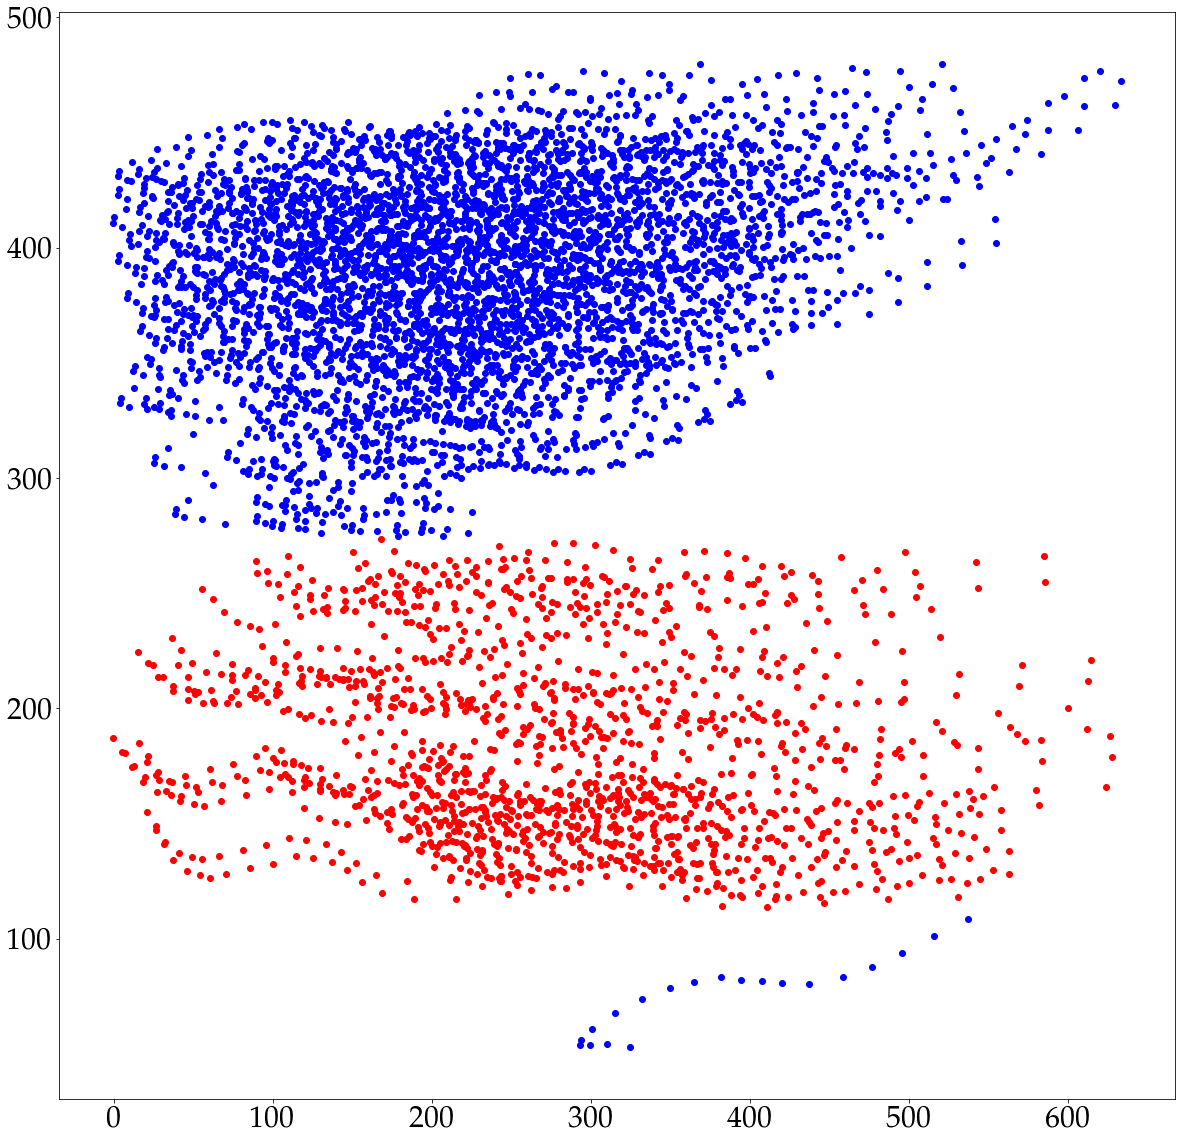

In [88]:
key = "cars1"
colors = ["red", "blue"]


plt.figure(figsize = (20, 20))
for col in range(motion_data[key]["y"].shape[1]):
    plt.scatter(motion_data[key]["y"][0, col],
                motion_data[key]["y"][1, col],
#                 alpha = 0.5,
                color = colors[int(motion_data[key]["s"][col])]);

In [127]:
%ls ..

data/
Draft.ipynb
group/
Matthys-Ratnamogan-Sayem-MVA-Supervised-Learning-Project2.zip
perso/
project2-cachan17.pdf
README.md
report/
tools/


TypeError: savefig() missing 1 required positional argument: 'fname'

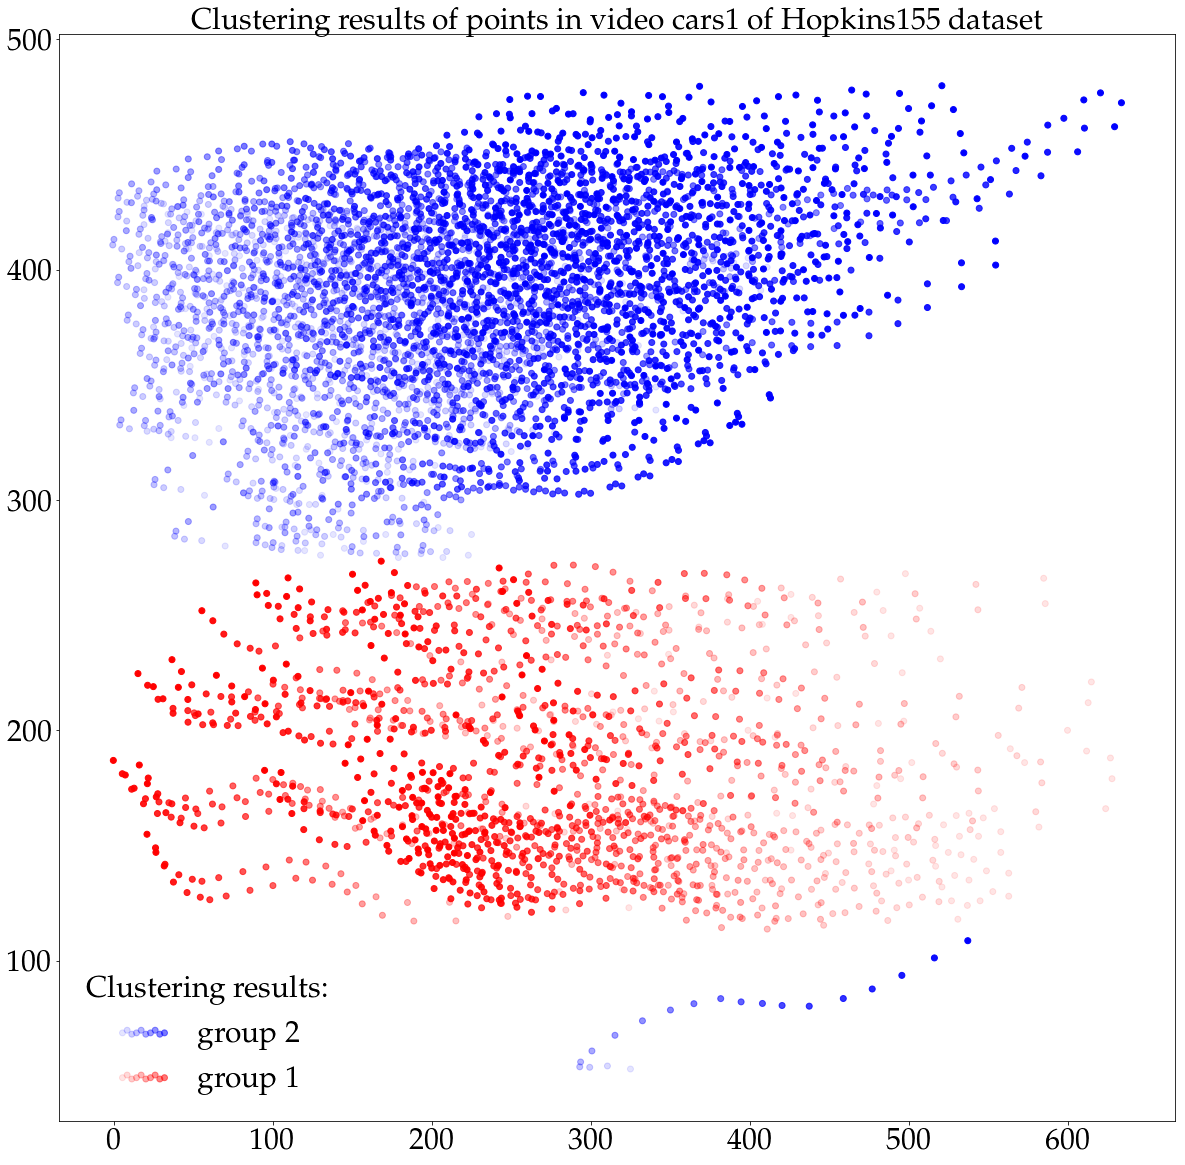

In [123]:
key = "cars1"
colors = {0: 0, 1: 2, 2:1}
legends = {0: "group 1", 1: "group 2", 2: "group 3"}
nbr_frames = motion_data[key]["frames"]
nbr_classes = motion_data[key]["s"].max() + 1

alphas = np.linspace(0.1, 1, nbr_frames)
rgba_colors = np.zeros((nbr_frames, 4))
rgba_colors[:, 3] = alphas



plt.figure(figsize = (20, 20))
for col in range(motion_data[key]["y"].shape[1]):
    cur_index = int(motion_data[key]["s"][col])
    rgba_colors[:, colors[cur_index]] = 1.0
    if type(legends[cur_index]) == str:
        cur_legend = legends[cur_index]
        legends[cur_index] = 0
    else:
        cur_legend = None
    plt.scatter(motion_data[key]["y"][0, col],
                motion_data[key]["y"][1, col],
                color = rgba_colors,
                label = cur_legend);
    rgba_colors[:, colors[int(motion_data[key]["s"][col])]] = 0

leg = plt.legend(fontsize = 30, scatterpoints = 10, ncol = 1, frameon=False);
leg.set_title(r"Clustering results: " , prop = {'size': 30})
plt.title(r"Clustering results of points in video {} of Hopkins155 dataset".format(key), size = 30);
legends = {0: "group 1", 1: "group 2", 2: "group 3"}
plt.savefig("../i");